# Annotator agreement visualizations
Code to make plots of inter-annotator agreement for entity and relation annotation.

## Entity IAA
The code to calculate the raw numbers for this section is found in the script `annotation/iaa/entity_iaa.py`. An example of how to run this script is:

```
python entityIAA.py path/to/project/dir > my_output_file.py
```

Since we use code from the [bratiaa](https://github.com/kldtz/bratiaa) project for this script, there is a specific directory structure required in order to run it, which is specified in the module documentation at the top of the script.
<br>

I ran this script after each round of entity annotation on all annotators in order to get the double-blind IAA. Then, after final refinement of the guidelines and making one final gold standard annotation, I used the gold standard annotation as an "annotator" in order to calculate the single-blind IAA. This was somewhat labor-intensive, because due to the required directory structure, it involved a lot of copying and pasting on the command line; there is a lot of room for imptovement in efficiency here. The files being read in here are the result of this process.

In [47]:
import pandas as pd 
from io import StringIO
import matplotlib.pyplot as plt
%matplotlib inline
from os import listdir
from os.path import join, splitext
import numpy as np

### Read in files and pre-process data

In [48]:
# Define a function to read in the files
def read_entity_iaa(ent_iaa_path):
    """
    Read in the IAA from a bratiaa markdown file.
    
    parameters:
        ent_iaa_path, str: path to Markdown file 
        
    returns:
        dfs, dict: keys are IAA type names, values are df's with IAA values 
        overalls, dict: keys are overall names, values are 2-tuples of (mean, sd)
    """
    per_doc_inst_table = []
    per_label_inst_table = []
    overall_inst = ()
    per_doc_tok_table = []
    per_label_tok_table = []
    overall_tok = ()
    
    tok_inst_counter = 0   # 0: none
                           # 1: in instance-based 
                           # 2: in token-based
    doc_label_counter = 0  # 0: reading irrelevant lines 
                           # 1: reading per-doc 
                           # 2: reading per-label
                
    # Read info for tables 
    with open(ent_iaa_path) as myfile:
        lines = myfile.readlines()
        for line in lines:
            # Check which section we're in 
            if 'Instance-based' in line:
                tok_inst_counter = 1
            elif 'Token-based' in line:
                tok_inst_counter = 2
            
            # Check which subsection we're in
            if 'Agreement per Document' in line:
                doc_label_counter = 1
            elif 'Agreement per Label' in line:
                doc_label_counter = 2
                
            # Check if this is a line to read 
            if line[0] == '|':
                # Put it in the proper table list 
                if tok_inst_counter == 1 and doc_label_counter == 1:
                    per_doc_inst_table.append(line)
                elif tok_inst_counter == 1 and doc_label_counter == 2:
                    per_label_inst_table.append(line)
                elif tok_inst_counter == 2 and doc_label_counter == 1:
                    per_doc_tok_table.append(line)
                elif tok_inst_counter == 2 and doc_label_counter == 2:
                    per_label_tok_table.append(line)
            elif '* Mean F1:' in line:
                first_colon = line.index(':')
                second_colon = line.index(':', first_colon+1)
                first_comma = line.index(',', first_colon+1)
                mean = float(line[first_colon+1:first_comma].strip())
                sd = float(line[second_colon+1:].strip())
                if tok_inst_counter == 1:
                    overall_inst = (mean, sd)
                elif tok_inst_counter == 2:
                    overall_tok = (mean, sd)
                    
    # Convert markdown tables to pandas df 
    tables = {'inst_doc':per_doc_inst_table, 'inst_label':per_label_inst_table,
             'tok_doc':per_doc_tok_table, 'tok_label':per_label_tok_table}
    dfs = {}
    for table_name, table_contents in tables.items():
        # Convert string to readable object
        DATA = StringIO("\n".join(table_contents))
        # Read into pandas df 
        df = pd.read_csv(DATA, sep="|", index_col=1, header=0)
        # Drop the NA columns caused by the pipe chars on either side of the table
        df = df.dropna(axis=1, how='all')
        # Strip whitespace from column and index names 
        df.columns = df.columns.str.strip()
        df.index = df.index.str.strip()
        # Drop the underline row 
        df = df[df['Mean F1'].str.contains("-")==False]
        # Drop rows with 'nan'
        df = df[df['Mean F1'].str.contains('nan')==False]
        # Convert str to int 
        df['Mean F1'] = pd.to_numeric(df['Mean F1'], downcast='float', errors='ignore')
        df['SD F1'] = pd.to_numeric(df['SD F1'], downcast='float', errors='ignore')
        # Add to dict
        dfs[table_name] = df
            
    # Make dict for overall values 
    overalls = {'inst':overall_inst, 'tok':overall_tok}
    
    return dfs, overalls

In [49]:
# Define paths for each round
double_ent_paths = {'Round 1': '../data/straying_off_topic_data/iaa/ten_gold_standard_docs.md',
        'Round 2': '../data/straying_off_topic_data/iaa/second_ten_gold_standard_docs.md',
        'Round 3': '../data/straying_off_topic_data/iaa/third_ten_gold_standard_docs_entityIAA.md',
        'Round 4': '../data/straying_off_topic_data/iaa/top_ten_journals_entity_IAA.md',
        'Round 5': '../data/straying_off_topic_data/iaa/five_gold_standard_docs_entity_IAA_FINAL_doc.md',
        'Round 6': '../data/straying_off_topic_data/iaa/last_ten_with_types.md'}

single_ent_path = '../data/straying_off_topic_data/iaa/single_blind_entity_iaa/'

In [50]:
# Read in the files
double_ents = {}
for r, path in double_ent_paths.items():
    _, r_overalls = read_entity_iaa(path)
    double_ents[r] = r_overalls
    
single_ents_sep_annotators = {}
for f in listdir(single_ent_path):
    _, overall = read_entity_iaa(join(single_ent_path, f))
    name = splitext(f)[0]
    single_ents_sep_annotators[name] = overall

In [51]:
# Process the double blind entity dictionary
ent_round_double = {k: v['inst'] for k, v in double_ents.items()}
ent_round_double

{'Round 1': (0.322, 0.097),
 'Round 2': (0.56, 0.098),
 'Round 3': (0.335, 0.072),
 'Round 4': (0.462, 0.039),
 'Round 5': (0.512, 0.033),
 'Round 6': (0.61, 0.0)}

In [52]:
# Process the single blind entity dictionary
# Get the individual values we want
ent_round_single = {}
for docset in ['set1', 'set2', 'set3', 'set4', 'set5', 'set6']:
    round_name = f'round_{docset[-1]}'
    ent_round_single[round_name] = [v['inst'][0] for k, v in single_ents_sep_annotators.items() if docset in k]
# Then get mean and standard deviation
ent_round_single = {k:(sum(v)/len(v), np.std(v)) for k, v in ent_round_single.items()}
ent_round_single

{'round_1': (0.151, 0.05032395056034453),
 'round_2': (0.3325, 0.03506066171651643),
 'round_3': (0.3105, 0.057482606064791456),
 'round_4': (0.3296666666666667, 0.04195500235040183),
 'round_5': (0.617, 0.03698648401781389),
 'round_6': (0.702, 0.043999999999999984)}

In [53]:
# Number of annotators and docs per round
ann_num = {'Round 1': 4,
          'Round 2': 4,
          'Round 3': 4,
          'Round 4': 3,
          'Round 5': 3, 
          'Round 6': 2}

doc_num = {'Round 1': 10,
          'Round 2': 10,
          'Round 3': 10,
          'Round 4': 10,
          'Round 5': 5, 
          'Round 6': 10}

## Relation IAA
This code was written from scratch, and so doesn't suffer as many limitations in terms of directory structure. It still required some command-line copying, as I needed to make a directory for the gold standard as an annotator, that has the same subdirectory structure as the original annotators, but I didn't have to move anything besides that. Additionally, the data is saved in a csv, instead of a Markdown file, which makes it easier to read in.

In [54]:
# Define function to read in the data
def read_relation_iaa(path, prefix):
    """
    Read in the relation IAA data. 
    
    parameters:
        path, str: path to directory containing relation IAA files 
        prefix, str: the prefix used to save the files 
    
    returns: 
        per_doc, df: IAA per document 
        overall, df: agg df with overall mean and SD
    """
    per_doc = pd.read_csv(f'{path}/{prefix}_per_doc.csv', index_col=0, header=1)
    overall = pd.read_csv(f'{path}/{prefix}_overall.csv', index_col=0)
    
    return per_doc, overall

In [55]:
# Define paths
double_pre_path = '../data/straying_off_topic_data/iaa/relation_double_iaa'
single_pre_path = '../data/straying_off_topic_data/iaa/relation_single_blind'

rel_double_prefixes = {'Round 1': 'ten_gold_standard_docs_RELATIONS_LOOSE',
        'Round 2': 'second_ten_gold_standard_docs_RELATIONS_LOOSE',
        'Round 3': 'third_ten_gold_standard_docs_RELATIONS_LOOSE',
        'Round 4': 'ten_top_journal_abstracts_RELATIONS_LOOSE',
        'Round 5': 'five_gold_standard_docs_RELATIONS_LOOSE',
        'Round 6': 'last_ten_gold_standard_docs_RELATIONS_LOOSE'}

rel_single_prefixes = {k:'_'.join(v.split('_')[:-1]) for k,v in rel_double_prefixes.items()}

In [56]:
# Read in files
rel_double_overall_dfs = {}
for r, prefix in rel_double_prefixes.items():
    _, overall = read_relation_iaa(double_pre_path, prefix)
    rel_double_overall_dfs[r] = overall
    
rel_single_overall_dfs = {}
for r, prefix in rel_single_prefixes.items():
    _, overall = read_relation_iaa(single_pre_path, prefix)
    rel_single_overall_dfs[r] = overall

In [57]:
# Get data in same tuple format as we did for entities
rel_double_overall = {k:(v.loc['mean', 'iaa'], v.loc['std', 'iaa']) for k,v in rel_double_overall_dfs.items()}
rel_single_overall = {k:(v.loc['mean', 'iaa'], v.loc['std', 'iaa']) for k,v in rel_single_overall_dfs.items()}

In [58]:
rel_double_overall

{'Round 1': (0.3684068041579708, 0.3089514611019544),
 'Round 2': (0.508442390942391, 0.3583646815268073),
 'Round 3': (0.4276726309892768, 0.3006259347057197),
 'Round 4': (0.5378675194034142, 0.33651040113896125),
 'Round 5': (0.5628968253968253, 0.3258831175612101),
 'Round 6': (0.5853787878787878, 0.3551762155859358)}

In [59]:
rel_single_overall

{'Round 1': (0.4166222537924035, 0.3025879901518081),
 'Round 2': (0.5768294096970568, 0.35107302996766776),
 'Round 3': (0.5319287103737105, 0.3017777949741924),
 'Round 4': (0.6344905167965663, 0.32523277818783025),
 'Round 5': (0.7045723733174938, 0.3062086722184697),
 'Round 6': (0.7158123086064262, 0.3345555708614989)}

In [60]:
rel_ann_num = {'Round 1': 4,
          'Round 2': 3,
          'Round 3': 3,
          'Round 4': 3,
          'Round 5': 2, 
          'Round 6': 2}

## Make plot

In [61]:
round_names = ent_round_double.keys()
db_means = [v[0] for k,v in ent_round_double.items()]
db_std = [v[1] for k,v in ent_round_double.items()]
sg_means = [v[0] for k,v in ent_round_single.items()]
sg_std = [v[1] for k,v in ent_round_single.items()]

In [62]:
rel_round_names = rel_double_overall.keys()
db_rel_means = [v[0] for k,v in rel_double_overall.items()]
db_rel_std = [v[1] for k,v in rel_double_overall.items()]
sg_rel_means = [v[0] for k,v in rel_single_overall.items()]
sg_rel_std = [v[1] for k,v in rel_single_overall.items()]

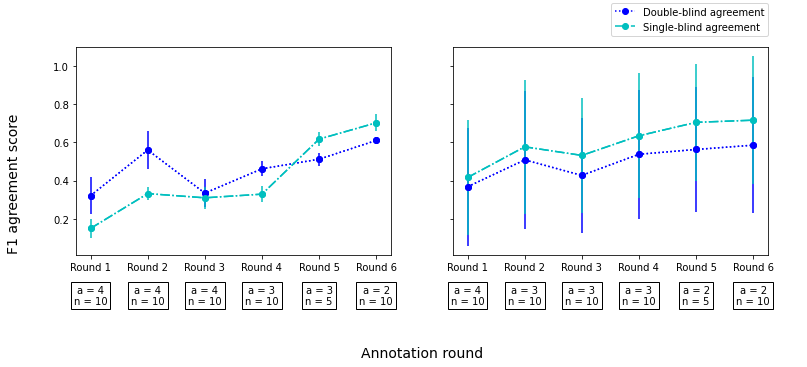

In [63]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,5))

ax1.plot(round_names, db_means,'bo:', label='Double-blind agreement')
ax1.errorbar(round_names, db_means, yerr=db_std, fmt='bo:')
ax1.plot(round_names, sg_means, 'co-.', label='Single-blind agreement') 
ax1.errorbar(round_names, sg_means, yerr=sg_std, fmt='co-.')
xtick_locs, xtick_labels = ax1.get_xticks(), ax1.get_xticklabels()
for xtick_loc, xtick_label in zip(xtick_locs, ann_num.keys()):
    ann_text = f'a = {ann_num[xtick_label]}'
    doc_text = f'n = {doc_num[xtick_label]}'
    box_text = f'{ann_text}\n{doc_text}'
    t = ax1.text(xtick_loc, -0.2, box_text, ha='center', va='center',
                 size=10, bbox=dict(boxstyle="square,pad=0.3", facecolor='white'))

ax2.plot(rel_round_names, db_rel_means,'bo:', label='Double-blind agreement')
ax2.errorbar(rel_round_names, db_rel_means, yerr=db_rel_std, fmt='bo:')
ax2.plot(rel_round_names, sg_rel_means, 'co-.', label='Single-blind agreement') 
ax2.errorbar(rel_round_names, sg_rel_means, yerr=sg_rel_std, fmt='co-.')
xtick_locs, xtick_labels = ax2.get_xticks(), ax2.get_xticklabels()
for xtick_loc, xtick_label in zip(xtick_locs, ann_num.keys()):
    ann_text = f'a = {rel_ann_num[xtick_label]}'
    doc_text = f'n = {doc_num[xtick_label]}'
    box_text = f'{ann_text}\n{doc_text}'
    t = ax2.text(xtick_loc, -0.2, box_text, ha='center', va='center',
                 size=10, bbox=dict(boxstyle="square,pad=0.3", facecolor='white'))

fig.supylabel('F1 agreement score', fontsize=14)
fig.supxlabel('Annotation round', fontsize=14)
fig.subplots_adjust(bottom=0.3, left=0.1)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.756,0.9))

fig.savefig('../data/straying_off_topic_data/iaa/single_double_blind_iaa_semantic_names.png', bbox_inches='tight', dpi=300)